<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [11]</a>'.</span>

In [1]:
import sys
# !{sys.executable} -m pip install shap
from glob import glob
import numpy as np
import joblib
import os
import pandas as pd
import json

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tqdm.notebook import tqdm
import seaborn as sns
from collections import Counter

# SHAP
import shap

In [2]:
# glob(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'database','*.csv.gz'))

In [3]:
trainsize=[ 0.1,0.3, 0.5, 0.7,0.8]

In [4]:


gaussian_kernel = RBF()

# remove basic linear models (ridge, lasso, elastic) and expensive models (gpr)

models = {
    # 'ridge': Ridge(),
    # 'lasso': Lasso(),
    # 'elastic': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    # 'grad': GradientBoostingRegressor(),
    # 'svr': SVR(),
    'krr': KernelRidge(),
    # 'gpr': GaussianProcessRegressor()
}

param_grid = {
    'ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
    },
    'knn': {
        'n_neighbors': [1,5,10],
        'weights': ['uniform', 'distance']
    },
    'rfr': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'grad': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7]
    },
    'svr': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.01, 0.001]
    },
    'krr': {
        'kernel': ['linear', 'laplacian', 'rbf'],
        'alpha': [0.001, 0.01, 0.1, 1],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'gpr': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': [gaussian_kernel]
    },
    'lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    'elastic': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000]
    }
}


In [5]:
def gridsearch(model,X_tr, y_tr,X_tst,y_tst):
    """
    Perform GridSearchCV for a given model

    parameters
    ----------
    model: str
        Name of model

    X_tr: np.array
        X training

    y_tr: np.array
        Y Training

    X_tst: np.array
        X test

    y_tst: np.array
        y test

    Returns
    -------
    scores: dict
        scored models
    """
    st = time.time()
    # Grab model and model parameters to perform gridsearchcv
    current_model = models[model]
    current_param_grid = param_grid[model]

    grid_search = GridSearchCV(current_model, current_param_grid, cv=5,n_jobs=-1)

    print(f'Now fitting {model}... ')

    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_

    print(f'Completed fitting {model} in {time.time() - st:.4f} seconds. ')

    # Take the best model and evaluate using known metrics
    model=best_model
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    y_tr_pred = model.predict(X_tr)
    y_tst_pred = model.predict(X_tst)

    # plt.scatter(y_tr,y_tr_pred)
    # plt.scatter(y_tst,y_tst_pred)
    # plt.scatter(y_tr, y_tr)
    # plt.scatter(y_tst,y_tst)
    # plt.show()
            
    scores['MSE_train'] = mean_squared_error(y_tr, y_tr_pred),
    scores['R2_train'] = r2_score(y_tr, y_tr_pred)
    scores['MAE_train'] = mean_absolute_error(y_tr, y_tr_pred)
    
    scores['MSE_test'] = mean_squared_error(y_tst, y_tst_pred)
    scores['R2_test'] = r2_score(y_tst, y_tst_pred)
    scores['MAE_test'] = mean_absolute_error(y_tst, y_tst_pred)
    print(f"Train R2 {scores['R2_train']:.4f}")
    print(f"Test R2 {scores['R2_test']:.4f}")
    print(f"Train MAE {scores['MAE_train']:.4f}")
    print(f"Test MAE {scores['MAE_test']:.4f}")
    print()
    return scores, best_model



In [6]:
# for r in trainsize:
#     Y=pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'database','y.csv.gz'), compression='gzip',index_col=0)
#     X=pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'database',f'Morgan_sub.csv.gz'), compression='gzip',index_col=0)
#     print(X.shape[1])
#     train,test=train_test_split(list(X.index), train_size=0.8,test_size=0.2,random_state=42)
#     X_train, X_test, y_train, y_test = X.loc[train].to_numpy(), X.loc[test].to_numpy(), Y.loc[train].to_numpy().flatten(), Y.loc[test].to_numpy().flatten()
    
#     scaler = MinMaxScaler
#     x_scaler = scaler((-1, 1))
#     y_scaler = scaler((-1, 1))
    
#     X_val = np.empty(X.shape)
#     y_val = np.empty(Y.shape)
#     y_train, y_test, y_val = y_train.reshape(-1, 1), y_test.reshape(-1, 1), y_val.reshape(-1, 1)
#     X_train = x_scaler.fit_transform(X_train)
#     X_test = x_scaler.transform(X_test)
#     X_val = x_scaler.transform(X_val)
#     y_train = y_scaler.fit_transform(y_train)
#     y_test = y_scaler.transform(y_test)
#     y_val = y_scaler.transform(y_val)
    
#     components=5
#     pca = PCA(n_components=components)
#     X_train, X_test = pca.fit_transform(X_train), pca.transform(X_test)
    
#     with open(f'PCA{components}_{r}_Morgan_train.bin','wb') as f:
#         joblib.dump({'X':X_train,'y':y_train},f)
#     with open(f'PCA{components}_{r}_Morgan_test.bin','wb') as f:
#         joblib.dump({'X':X_test,'y':y_test},f)
    
#     with open(f'PCA{components}_{r}_Morgan_scaler.bin','wb') as f:
#         joblib.dump(y_scaler,f)

In [7]:
scaler = MinMaxScaler
x_scaler = scaler((-1, 1))
y_scaler = scaler((-1, 1))


In [8]:
Y=pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'database','y.csv.gz'), compression='gzip',index_col=0)
Reps=['CM', 'MACCS', 'PI', 'RDKit', 'Morgan']
      # , 'SOAP']
divisions=["AB","sub"]

test_models_out={}
for r in Reps:
    test_models_out[r]={}
    for d in divisions:
        test_models_out[r][d]={}
        print(f'Start: {r}_{d}')
        X_path=os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'database',f'{r}_{d}.csv.gz')
        if os.path.exists(X_path):
            X=pd.read_csv(X_path, compression='gzip',index_col=0)
            print(X.shape[1])
            train,test=train_test_split(list(X.index), train_size=0.8,test_size=0.2,random_state=42)
            X_train, X_test, y_train, y_test = x_scaler.fit_transform(X.loc[train].to_numpy()), x_scaler.transform(X.loc[test].to_numpy()), y_scaler.fit_transform(Y.loc[train].to_numpy()).flatten(), y_scaler.transform(Y.loc[test].to_numpy()).flatten()
            
            scaler = MinMaxScaler
            x_scaler = scaler((-1, 1))
            y_scaler = scaler((-1, 1))
            
            X_val = np.empty(X.shape)
            y_val = np.empty(Y.shape)
            y_train, y_test, y_val = y_train.reshape(-1, 1), y_test.reshape(-1, 1), y_val.reshape(-1, 1)
            X_train = x_scaler.fit_transform(X_train)
            X_test = x_scaler.transform(X_test)
            X_val = x_scaler.transform(X_val)
            y_train = y_scaler.fit_transform(y_train)
            y_test = y_scaler.transform(y_test)
            y_val = y_scaler.transform(y_val)
            
            scoring={}
            t0_init=time.perf_counter()
            for m in models.keys():
                t0=time.perf_counter()
                scores,model=gridsearch(m,X_train, y_train,X_test,y_test)
                tf=time.perf_counter()-t0
                scores['timing']=tf
                scoring[m]=scores
                print(m,tf)
            print(f"Overall {time.perf_counter()-t0_init:.2f}")
            stat_df=pd.concat([pd.DataFrame.from_dict(v).rename(index={0:k}) for k,v in scoring.items()])
            test_models_out[r][d]=stat_df
        print()
    print()

Start: CM_AB
42
Now fitting knn... 
Completed fitting knn in 0.9050 seconds. 
Now scoring model... 
Train R2 0.9829
Test R2 0.2300
Train MAE 0.0106
Test MAE 0.2097

knn 1.0718397910000022
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 39.6231 seconds. 
Now scoring model... 
Train R2 0.8804
Test R2 0.4064
Train MAE 0.0792
Test MAE 0.1851

rfr 39.66825700000004
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 10.7775 seconds. 
Now scoring model... 
Train R2 0.8578
Test R2 0.4140
Train MAE 0.0851
Test MAE 0.1816

krr 11.081258791999971
Overall 51.82

Start: CM_sub
42
Now fitting knn... 
Completed fitting knn in 0.2186 seconds. 
Now scoring model... 
Train R2 1.0000
Test R2 0.3665
Train MAE 0.0000
Test MAE 0.1898

knn 0.28230999999982487
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 48.0501 seconds. 
Now scoring model... 
Train R2 0.9236
Test R2 0.4162
Train MAE 0.0622
Test MAE 0.1738

rfr 48.21932595800013
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 10.2142 seconds. 
Now scoring model... 
Train R2 0.9725
Test R2 0.4809
Train MAE 0.0323
Test MAE 0.1696

krr 10.51186520799979
Overall 59.01


Start: MACCS_AB
167
Now fitting knn... 
Completed fitting knn in 0.2609 seconds. 
Now scoring model... 
Train R2 0.7547
Test R2 0.6075
Train MAE 0.1145
Test MAE 0.1494

knn 0.38217770799997197
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 22.6610 seconds. 
Now scoring model... 
Train R2 0.8832
Test R2 0.7377
Train MAE 0.0734
Test MAE 0.1158

rfr 22.733532374999868
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 15.7981 seconds. 
Now scoring model... 
Train R2 0.8742
Test R2 0.7426
Train MAE 0.0794
Test MAE 0.1203

krr 16.061180208999986
Overall 39.18

Start: MACCS_sub
167
Now fitting knn... 
Completed fitting knn in 0.2861 seconds. 
Now scoring model... 
Train R2 0.8616
Test R2 0.6865
Train MAE 0.0665
Test MAE 0.1280

knn 0.40605824999988727
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 19.4783 seconds. 
Now scoring model... 
Train R2 0.8504
Test R2 0.7506
Train MAE 0.0825
Test MAE 0.1153

rfr 19.575322458999835
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 16.7231 seconds. 
Now scoring model... 
Train R2 0.8359
Test R2 0.7621
Train MAE 0.0881
Test MAE 0.1166

krr 18.06549166600007
Overall 38.05


Start: PI_AB
400
Now fitting knn... 
Completed fitting knn in 0.3254 seconds. 
Now scoring model... 
Train R2 0.0413
Test R2 -0.0483
Train MAE 0.2391
Test MAE 0.2583

knn 0.5870939170001748
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 39.3929 seconds. 
Now scoring model... 
Train R2 0.0300
Test R2 -0.0122
Train MAE 0.2362
Test MAE 0.2481

rfr 39.401274707999846
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 32.0235 seconds. 
Now scoring model... 
Train R2 0.0036
Test R2 -0.0038
Train MAE 0.2391
Test MAE 0.2470

krr 35.553724957999975
Overall 75.54

Start: PI_sub


Start: RDKit_AB
2048
Now fitting knn... 
Completed fitting knn in 0.9679 seconds. 
Now scoring model... 
Train R2 0.6578
Test R2 0.4278
Train MAE 0.1343
Test MAE 0.1753

knn 2.258916750000026
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 759.6394 seconds. 
Now scoring model... 
Train R2 0.9168
Test R2 0.5925
Train MAE 0.0636
Test MAE 0.1467

rfr 759.7548084589998
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 173.1845 seconds. 
Now scoring model... 
Train R2 0.9058
Test R2 0.6559
Train MAE 0.0639
Test MAE 0.1406

krr 228.49233174999972
Overall 990.51

Start: RDKit_sub
2048
Now fitting knn... 
Completed fitting knn in 0.9957 seconds. 
Now scoring model... 
Train R2 0.9908
Test R2 0.5708
Train MAE 0.0031
Test MAE 0.1207

knn 2.2247264580000774
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 1286.1756 seconds. 
Now scoring model... 
Train R2 0.9603
Test R2 0.7401
Train MAE 0.0409
Test MAE 0.1063

rfr 1286.366534583
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 173.4762 seconds. 
Now scoring model... 
Train R2 0.9674
Test R2 0.7240
Train MAE 0.0321
Test MAE 0.1232

krr 229.602939333
Overall 1518.20


Start: Morgan_AB
2048
Now fitting knn... 
Completed fitting knn in 0.9527 seconds. 
Now scoring model... 
Train R2 0.6274
Test R2 0.4035
Train MAE 0.1443
Test MAE 0.1883

knn 2.2361489579998306
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 817.9717 seconds. 
Now scoring model... 
Train R2 0.9095
Test R2 0.6991
Train MAE 0.0661
Test MAE 0.1229

rfr 818.1384922920001
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 173.3262 seconds. 
Now scoring model... 
Train R2 0.9134
Test R2 0.6730
Train MAE 0.0671
Test MAE 0.1425

krr 229.7387606249995
Overall 1050.11

Start: Morgan_sub
2048
Now fitting knn... 
Completed fitting knn in 0.9742 seconds. 
Now scoring model... 
Train R2 0.9998
Test R2 0.7323
Train MAE 0.0007
Test MAE 0.1121

knn 2.2092709159996957
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 877.3175 seconds. 
Now scoring model... 
Train R2 0.9868
Test R2 0.9109
Train MAE 0.0228
Test MAE 0.0592

rfr 877.4972214170002
Now fitting krr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed fitting krr in 182.6556 seconds. 
Now scoring model... 
Train R2 0.9959
Test R2 0.8481
Train MAE 0.0132
Test MAE 0.0923

krr 237.40917916699982
Overall 1117.12




Completed fitting knn in 0.2422 seconds. 
Now scoring model... 
Train R2 0.0413
Test R2 -0.0481
Train MAE 0.2390
Test MAE 0.2583

knn 0.294758545991499
Now fitting rfr... 


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Completed fitting rfr in 32.4422 seconds. 
Now scoring model... 
Train R2 0.0310
Test R2 -0.0142
Train MAE 0.2362
Test MAE 0.2485

rfr 32.45411872200202
Now fitting krr... 


Completed fitting krr in 56.8570 seconds. 
Now scoring model... 


Train R2 0.0036
Test R2 -0.0038
Train MAE 0.2391
Test MAE 0.2470

krr 59.6571921230061
Overall 92.41

Start: PI_sub


Start: RDKit_AB


2048
Now fitting knn... 


Completed fitting knn in 0.8124 seconds. 
Now scoring model... 


Train R2 0.6618
Test R2 0.4229
Train MAE 0.1336
Test MAE 0.1759

knn 1.0254372539930046
Now fitting rfr... 


/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Completed fitting rfr in 812.1087 seconds. 
Now scoring model... 
Train R2 0.9261
Test R2 0.5952
Train MAE 0.0598
Test MAE 0.1457

rfr 812.2225870379916
Now fitting krr... 


Completed fitting krr in 339.4713 seconds. 
Now scoring model... 


Train R2 0.9058
Test R2 0.6559
Train MAE 0.0639
Test MAE 0.1406

krr 397.15621002498665
Overall 1210.40

Start: RDKit_sub


2048
Now fitting knn... 


Completed fitting knn in 0.8031 seconds. 
Now scoring model... 
Train R2 0.9908
Test R2 0.5708
Train MAE 0.0031
Test MAE 0.1207

knn 0.9887154150055721
Now fitting rfr... 


/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Completed fitting rfr in 1319.4314 seconds. 
Now scoring model... 
Train R2 0.9599
Test R2 0.7367
Train MAE 0.0414
Test MAE 0.1072

rfr 1319.6116359669977
Now fitting krr... 


Completed fitting krr in 336.6384 seconds. 
Now scoring model... 


Train R2 0.9674
Test R2 0.7240
Train MAE 0.0321
Test MAE 0.1232

krr 390.8393551140034
Overall 1711.44


Start: Morgan_AB


2048
Now fitting knn... 


Completed fitting knn in 0.8043 seconds. 
Now scoring model... 
Train R2 0.6245
Test R2 0.4049
Train MAE 0.1451
Test MAE 0.1879

knn 0.9943582850100938
Now fitting rfr... 


/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Completed fitting rfr in 824.6623 seconds. 
Now scoring model... 
Train R2 0.9261
Test R2 0.6907
Train MAE 0.0569
Test MAE 0.1231

rfr 824.8092429920071
Now fitting krr... 


Completed fitting krr in 335.1831 seconds. 
Now scoring model... 


Train R2 0.9134
Test R2 0.6730
Train MAE 0.0671
Test MAE 0.1425

krr 389.03196678101085
Overall 1214.84

Start: Morgan_sub


2048
Now fitting knn... 


Completed fitting knn in 0.7995 seconds. 
Now scoring model... 
Train R2 0.9998
Test R2 0.7291
Train MAE 0.0007
Test MAE 0.1129

knn 0.9682911339914426
Now fitting rfr... 


/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/grierjones/miniconda3/envs/qml/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Completed fitting rfr in 892.1241 seconds. 
Now scoring model... 


Train R2 0.9869
Test R2 0.9103
Train MAE 0.0229
Test MAE 0.0598

rfr 892.3356356500008
Now fitting krr... 


Completed fitting krr in 335.7080 seconds. 
Now scoring model... 


Train R2 0.9959
Test R2 0.8481
Train MAE 0.0132
Test MAE 0.0923

krr 389.84434577199863
Overall 1283.15




In [9]:
results_df=[]
for k,v in test_models_out.items():
    if k!='PI':
        df=v['AB'][['R2_train','R2_test']].reset_index().melt(id_vars='index')
        df['model']=len(df)*[k]
        df['Feat']=['AB']*len(df)
        df1=v['sub'][['R2_train','R2_test']].reset_index().melt(id_vars='index')
        df1['model']=len(df1)*[k]
        df1['Feat']=['sub']*len(df1)
        results_df.append(pd.concat([df,df1],axis=0))
    else:
        df=v['AB'][['R2_train','R2_test']].reset_index().melt(id_vars='index')
        df['model']=len(df)*[k]
        df['Feat']=['AB']*len(df)   
        results_df.append(df)

results_df=pd.concat(results_df)    

In [10]:
test_models_out['Morgan']['sub']

,MSE_train,R2_train,MAE_train,MSE_test,R2_test,MAE_test,timing
knn,0.000016,0.999849,0.000670,0.029614,0.732261,0.112107,2.209271
rfr,0.001416,0.986807,0.022777,0.009852,0.910925,0.059225,877.497221
krr,0.000441,0.995894,0.013188,0.016804,0.848081,0.092255,237.409179


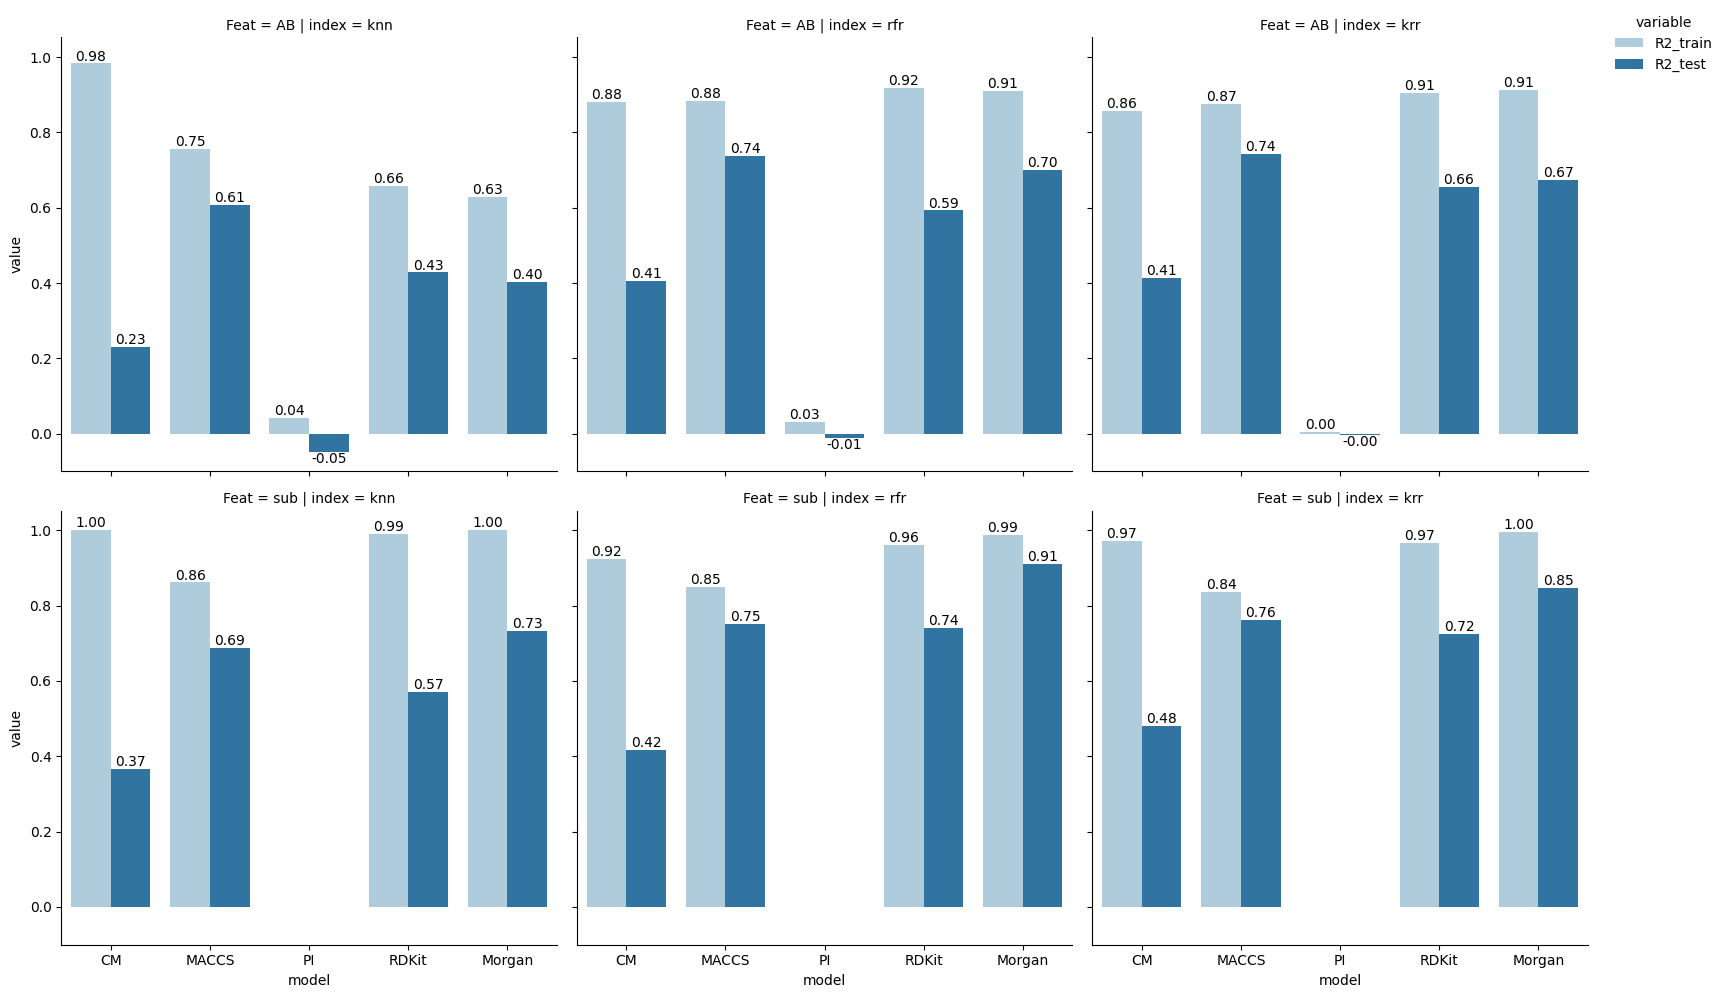

In [11]:
g=sns.catplot(data=results_df,x='model',hue='variable',y='value',col='index',row='Feat',kind='bar',palette=sns.color_palette('Paired',5),legend=True)

# extract the matplotlib axes_subplot objects from the FacetGrid
for ax in g.axes.ravel():
    
    # iterate through the axes containers
    for c in ax.containers:
        ax.bar_label(c, fmt='{:,.2f}')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        
plt.tight_layout()
plt.savefig("classical_funcfit.png",dpi=300,bbox_inches='tight')
plt.show()

In [12]:
def test_shap(n_feats,model):
    """
    Test dimensionality reduction using SHapely Additive Explanations (SHAP)
    
    params
    ------
    n_feats: int
        Number of best features to reduce too
        
    model: str
        Model to test

    returns
    -------
    scores: dict
        Dictionary containing evaluation metrics
    
    model: trained model
    
    """
    scaler = MinMaxScaler
    x_scaler = scaler((-1, 1))
    y_scaler = scaler((-1, 1))
    
    SHAPX=X.iloc[:,sorted_cols[-n_feats:]]
    
    X_train, X_test, y_train, y_test = x_scaler.fit_transform(SHAPX.loc[train].to_numpy()), x_scaler.transform(SHAPX.loc[test].to_numpy()), y_scaler.fit_transform(Y.loc[train].to_numpy()).flatten(), y_scaler.transform(Y.loc[test].to_numpy()).flatten()
    
    scores,model=gridsearch(model,X_train, y_train,X_test,y_test)
    with open(f'{n_feats}_SHAP_train.bin','wb') as f:
        joblib.dump({'X':X_train,'y':y_train},f)
    with open(f'{n_feats}_SHAP_test.bin','wb') as f:
        joblib.dump({'X':X_test,'y':y_test},f)
    with open(f'{n_feats}_SHAP_scaler.bin','wb') as f:
        joblib.dump(y_scaler,f)
        
    return scores,model
    

In [13]:
def test_pca(components,model):
    """
    Test dimensionality reduction using principal component analysis (PCA)
    
    params
    ------
    components: int
        Number of dimensions to reduce too
        
    model: str
        Model to test

    returns
    -------
    scores: dict
        Dictionary containing evaluation metrics

    model: trained model
    
    """
    scaler = MinMaxScaler
    x_scaler = scaler((-1, 1))
    y_scaler = scaler((-1, 1))
    
    pca = PCA(n_components=components)
    X_train, X_test, y_train, y_test = pca.fit_transform(x_scaler.fit_transform(X.loc[train])), pca.transform(x_scaler.transform(X.loc[test])), y_scaler.fit_transform(Y.loc[train].to_numpy()).flatten(), y_scaler.transform(Y.loc[test].to_numpy()).flatten()
    scores,model=gridsearch(model,X_train, y_train,X_test,y_test)
    with open(f'{components}_Morgan_train.bin','wb') as f:
        joblib.dump({'X':X_train,'y':y_train},f)
    with open(f'{components}_Morgan_test.bin','wb') as f:
        joblib.dump({'X':X_test,'y':y_test},f)
    with open(f'{components}_Morgan_scaler.bin','wb') as f:
        joblib.dump(y_scaler,f)
    return scores,model
    

In [14]:
def run_regular(model):
    """
    
    
    params
    ------    
    model: str
        Model to test

    returns
    -------
    scores: dict
        Dictionary containing evaluation metrics

    model: trained model
    
    """
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], Y.loc[train].to_numpy(), Y.loc[test].to_numpy()
    scores,model=gridsearch(model,X_train, y_train,X_test,y_test)
    
    return scores,model
    

In [15]:
model='rfr'
n_feats=5
components=5

# # Normal
scores,model=run_regular(model)



Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_va

Completed fitting rfr in 392.8392 seconds. 
Now scoring model... 
Train R2 0.9870
Test R2 0.9105
Train MAE 1.9104
Test MAE 4.9697



4097

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni

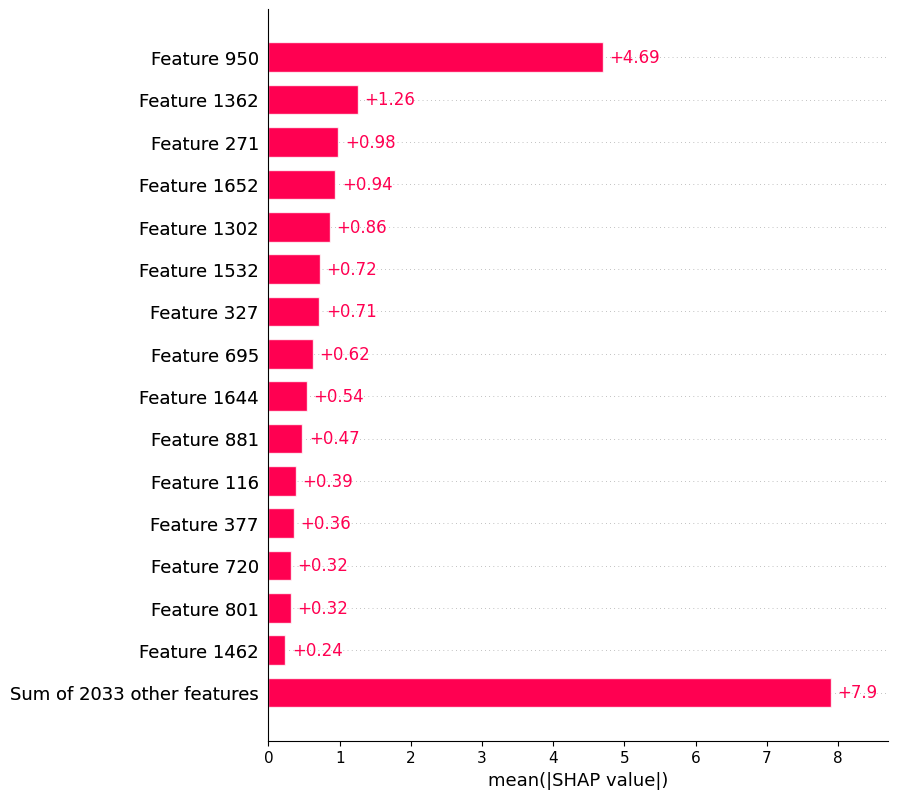

In [22]:
# # SHAP
explainer = shap.Explainer(model.predict, X_test,n_jobs=-1,max_evals=X.shape[1]*2 + 1)
shap_values = explainer(X_test)
shap.plots.bar(shap_values,max_display=16)


In [23]:
reduced={}
model='rfr'
for i in [5,16]:
    sorted_cols=np.argsort(np.mean(np.abs(shap_values.values),axis=0))
    shap_scores,shap_model=test_shap(i,model)
    
    #PCA
    pca_scores,pca_model=test_pca(i,model)

    reduced[i]={'SHAP':shap_scores,'PCA':pca_scores}

Now fitting rfr... 
Completed fitting rfr in 2.8898 seconds. 
Now scoring model... 
Train R2 0.2753
Test R2 0.2981
Train MAE 0.2065
Test MAE 0.2093

Now fitting rfr... 
Completed fitting rfr in 15.3113 seconds. 
Now scoring model... 
Train R2 0.9478
Test R2 0.6880
Train MAE 0.0489
Test MAE 0.1214

Now fitting rfr... 
Completed fitting rfr in 3.7406 seconds. 
Now scoring model... 
Train R2 0.6201
Test R2 0.5912
Train MAE 0.1434
Test MAE 0.1519

Now fitting rfr... 
Completed fitting rfr in 45.5127 seconds. 
Now scoring model... 
Train R2 0.9669
Test R2 0.7833
Train MAE 0.0387
Test MAE 0.1007



<BarContainer object of 2 artists>
<BarContainer object of 2 artists>
<BarContainer object of 2 artists>
<BarContainer object of 2 artists>


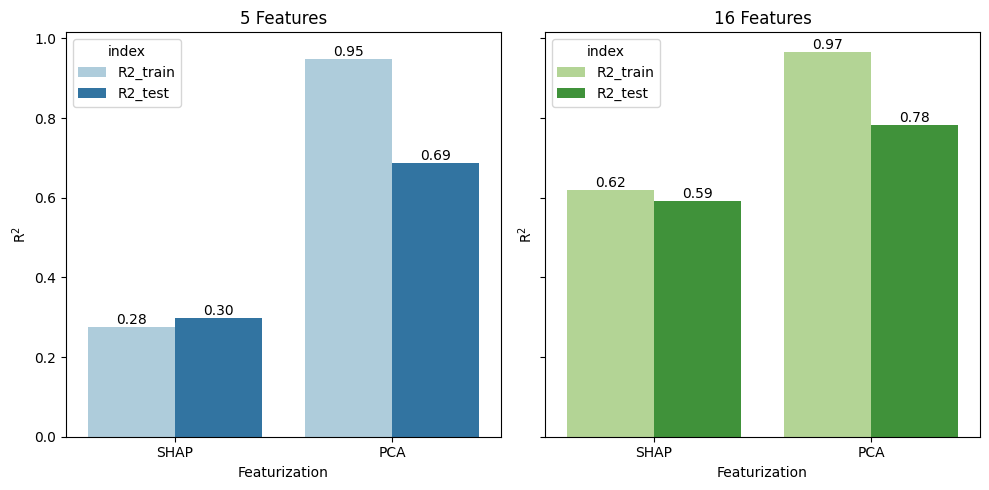

In [24]:
fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
pal=sns.color_palette('Paired',4)
for idx,(k,v) in enumerate(reduced.items()):
    df=pd.DataFrame.from_dict(v).loc[['R2_train','R2_test']].reset_index().melt(id_vars='index') 
    if idx==0:
        ax[idx]=sns.barplot(data=df,x='variable',hue='index',y='value',palette=[pal[idx],pal[idx+1]],ax=ax[idx])
    else:
        ax[idx]=sns.barplot(data=df,x='variable',hue='index',y='value',palette=[pal[2],pal[3]],ax=ax[idx])

    for container in ax[idx].containers:
        print(container)
        ax[idx].bar_label(container, fmt='{:,.2f}')
    ax[idx].set_title(f"{k} Features")
    ax[idx].set_xlabel('Featurization')
    ax[idx].set_ylabel("R$^{2}$")
plt.tight_layout()
plt.savefig('Feat_redR2.png',dpi=300,bbox_inches='tight')